# Expectations


- The Notebook caters to devleope an understanding on the `implementation of fastai-tabular` 
- There are few concepts that I have mentioned and `explained(briefy) [1cycle-policy, etc]`. I'd recommend going through `fastai course` for deeper understanding on those concepts
- Though I have been able acheive `top-1.5%` in Titanic. This notebook is at-best a `baseline` as far as good ML practices are concerned

-----------

- If this recieves a good feedback, I will try to implement the same using raw-pytorch code

----------

- `Disclaimer:`  Incase you are wondering why so many versions are there ?
    - It's primarily because this is my first kaggle kernel and I was learning abbut the with NB formatting options
    - Moreover, for version 24, I have made significant changes WRT version 22!

# Importing Libraries

In [1]:
import fastai
print("fastai version : ",fastai.__version__)

In [2]:
import pandas as pd
import numpy as np


from fastai import *
from fastai.tabular.all import *


import seaborn as sns
from matplotlib import pyplot as plt

# seed_value = 1000
# np.random.seed(seed_value) # cpu vars
# torch.manual_seed(seed_value) # cpu  vars
# random.seed(seed_value) # Python
pd.options.mode.chained_assignment = None  # default='warn'

# Dataset comparison

Here, we are using dataset which is a bit extension of classic titanic dataset. you can check out this: https://www.kaggle.com/pavlofesenko/titanic-extended

- **Titanic dataset**

In [3]:
test = pd.read_csv('/kaggle/input/titanic/test.csv')
train = pd.read_csv('../input/titanic/train.csv')

print(f"train shape: {train.shape} | test shape: {test.shape}")

In [4]:
#print("Null distribution")
#train.isnull().sum().sort_values(ascending = False).to_frame().T
# to check null values
train.isnull().sum()

- **Titanic extended dataset**
this comes from the wiki

In [5]:
test_ext = pd.read_csv('/kaggle/input/titanic-extended/test.csv')
train_ext = pd.read_csv('../input/titanic-extended/train.csv')


print(f"train extended shape: {train_ext.shape} | test extended shape: {test_ext.shape}")

In [6]:
train_ext.head() # this is different from the input dataset

In [7]:
#print("Null distribution")
#display(train_ext.isnull().sum().sort_values(ascending = False).to_frame().T)
train_ext.isnull().sum()

In [8]:
print("# Uniques")
display(train_ext.nunique().sort_values(ascending = False).to_frame().T)

# Feature Engg.

<u> Removing the following features </u>

- **High # Nulls**
    - Body : 804 Nulls
    - Cabin : 687 Nulls
    

- **Duplicate feature in `titanic-extended` and `titanic` data**
    - Age : Age_wiki
    - Class : Pclass
    - Name : Name_wiki
    - Embarked : Boarded
    
    
- **High Cardinality** 
* This means if the one feature has too many distinct values, we should not think about it
    - Name : 891 distinct values
    - PassengerId : 891 distinct values
    - Name_wiki : 889 distinct values
    - WikiId : 889 distinct values

In [9]:
# the use of columns.difference: create a new dataframe from existing dataframe with exclusion of the columns
req_cols = train_ext.columns.difference(['Body','Cabin' # high null features
                                         ,'Age','Class','Name','Embarked'# duplicate features
                                         ,'PassengerId','Name_wiki','WikiId'] # high cardinality features
                                       ).tolist()
print("Required features :", req_cols)

In [10]:
# filtering train and test on required columns
train_ext_fltr = train_ext[req_cols]
test_ext_fltr = test_ext[[col for col in req_cols if col != "Survived"]]

In [11]:
train_ext_fltr.head()

# Fastai tabular setup

##### Fastai tabular features
- Fastai has a couple cool features!
    - Handles `categorical data` (no encodings needed)
    - Handles `missing data`

In [12]:
# categorical features
cat_feat = train_ext_fltr.select_dtypes("O").columns.tolist()

# continuos features
cont_feat = train_ext_fltr.columns.difference(cat_feat+["Survived"]).tolist()

In [42]:
cat_feat

In [43]:
cont_feat

In [13]:
print("categorical data:")
display(train_ext_fltr[cat_feat].head(2))


print("continuos data:")
display(train_ext_fltr[cont_feat].head(2))

In [14]:
print("Null distribution")
display(train_ext_fltr.isnull().sum().sort_values(ascending = False).to_frame().T)

# TabularPandas 
- `TabularPandas` is fastai's datastructure for dataprocessing
- We need to add 3 transformation methods for data processing
    - Categorify: for handling categorical data. Fastai trains `embedding vectors` for categorical features
    - FillMissing : 
        - fills missing categorical data with `#na#` value . 
        - Also creates a new `is_na` type of feature for continuos features after imputing them with `mean/median`
    - Normalize : for normalizing the input data
    
    
- RandomSplitter 
    - As the name suggests, It splits the data in train and validation (80 :20)
---------------

>  What does the `params` means in TabularPandas 

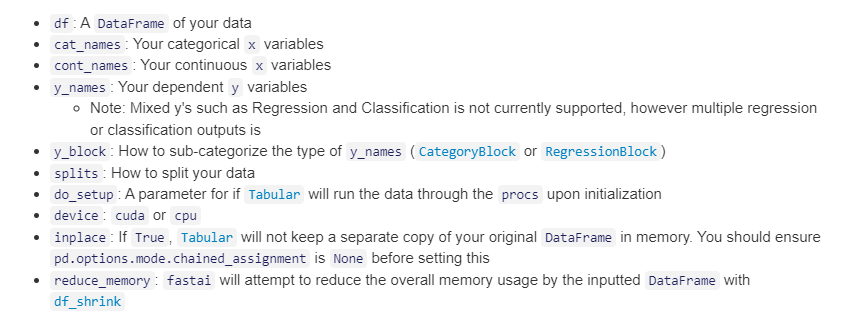

In [15]:
# splitting criteria - random split with 20% in validation set
splits = RandomSplitter(valid_pct=0.2, seed=1000)(range_of(train_ext_fltr))

tp = TabularPandas(train_ext_fltr, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_feat,
                   cont_names = cont_feat,
                   y_names='Survived',
                   y_block=CategoryBlock(),
                   splits=splits)

In [44]:
tp

# Fillmissing

- <u> Categorical Data </u> 

    - `#na#` is being used for imputing missing values (see `Lifeboat`)
    
    ------------------
- <u> Continuos Data </u>    
    - Fastai uses `Median` as default value for imputing the missing continous values
    - You can change the `Median` to `Mean` or `fixed_value`
    - `_na` features are created corresponding to each feature with missing values

    -  <u> code snippet to change imputation strategy </u>

    ```
    fm = FillMissing(fill_strategy=FillStrategy.median)
    to = TabularPandas(df, fm, cont_names=cont_names)
    ```

- **`Categorical Features`**

In [16]:
tp.show(max_n=3)

- **`Continuos Features`**

In [17]:
print("filling strategy:",tp.fill_strategy)

In [18]:
# we can see `_na` are added to cat_feat list
print("we can see that corresponding  _na (bool) features have been added wherever the columns have nulls")
print([col for col in cat_feat if  "_na" in col])

# Normalize

- Fastai normaizes continuos features using `(Xi - Xmean) / Xstd`

In [19]:
# normalize transform
norms = tp.procs.normalize

In [20]:
print("Mean/STD for each continuos col")
cont_col_stat = pd.DataFrame([norms.means, norms.stds], index = ["mean","std"])
cont_col_stat

- Let's check for one observation!
    - At `index = 299` the value for Age is `1.528887`
    - We can see that `Age_wiki` is standardized using `(Xi - Xmean) / Xstd`

In [21]:
# At index = 299 the value for Age_wiki is 1.528887
tp.conts.head(1)

In [22]:
# Mean & Std for Age feature
age_mean = cont_col_stat["Age_wiki"]["mean"]
age_std = cont_col_stat["Age_wiki"]["std"]

# standardizing age_wiki for 299 index
age_index_299 = train_ext_fltr.loc[299,"Age_wiki"]
age_std = (age_index_299 - age_mean)/age_std

print("Standard Age_wiki using (X-Xmean/Xstd) : ",age_std)

- Another fun thing!
    - Can someone tell me why aren't the calculated normalizing means matching when we are calculating means manually ?? `Its easy`

In [23]:
print("means calculated for normalizing")
display(cont_col_stat.iloc[0].to_frame().T)

print()

print("means calc manually")
display(train_ext[cont_feat].mean().to_frame().T)

- `Hint`

```
t1 = train_ext_fltr.iloc[tp.train.xs.index.tolist()].Age_wiki
t1.fillna(t1.median()).mean()
```

# Embeddings & Categorify

- When dealing with our categorical data, `after the missing-imputation step`,`Categorify` encodes your categories into labels using `Label encodings` 
- We then create what is called an `embedding matrix` mapped to the encodings . This allows for a higher dimentionality for relationships between the different categorical cardinalities

- **Categorify**

- Transforms columns that are in your `cat_names` into that categorical type, along with `label encoding` our categorical data

In [24]:
print("lets look at how label-encodings are done for categorical data \n")
label_encoding_dict = {cat : tp.procs.categorify[cat].o2i for cat in tp.cat_names}


print("label encodings for 'boarded' variable")
label_encoding_dict['Boarded']

- Lets look at how a row at `index 0` in the data is `label-encoded`, use below code

- You can see that the `Boarded` variable for value `Cherbourg` is encoded as `2` which can be verified in the above encodings

In [25]:
print("encoded data")
display(tp.items.iloc[[0]])

print()

print("original data - categorical values")
row = tp.items.iloc[0]
tp.decode_row(row).to_frame().T

- **Emebddings**

- `Ques`: Wait, why we need embeddings now, our categorical data is handled. Isn't it ?
- `Answer`: Not really. `Label encoding` the `nominal-data` can be a problem beacause you are `unnecessarily adding order` to the categories which was never there

-------------------

- `Ques` : Why Embeddings , why not 1-hot encodings ?
- `Ans` : Primarily because Embeddings allow a `better representation (unlike 1-hot encoding)` and are `less sparse` so handling is not an issue

------------------

- `Embedding size calculation logic`

- The rule is to use either a maximum embedding space of 600, or 1.6 times the cardinality raised to the 0.56, or written out as:
    
    ```
    min(600, (1.6 * {var.nunique)}^{0.56})
    ```
    
- Let's calculate these embedding sizes for our model to take a look-see:

In [26]:
emb_szs = get_emb_sz(tp)

print("Embedding size associated with each categorical feature:\n")
print({k:v for k,v in zip(tp.cat_names,emb_szs)})

- Okay, so ideally the first param should follow `embedding_size == # unique categories`

- However, you see the counts is 1 more for `Sex`, `Ticket` and `Age_wiki_na` , why ?
    - Honestly, even I dont know but let me try!
    - Ans: The embedding `adds` an additional dimension(category) to handle `potential nulls (#na#)` for columns which have `NOT` seen Nulls 
    
    Ref : https://forums.fast.ai/t/size-of-matrix-in-colab-learner-not-matching/72017/6

In [27]:
print("# uniques in categorical features")
tp[cat_feat].nunique().to_frame().T

# Dataloader

- Now what's `Dataloader!!`

> PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.


----------------
--------------

- Okay, but we have **TabDataLoader** and **TabularPandas**

- `TabDataLoader` : inherits from `Dataloader` class (is a Dataloader only)
- https://docs.fast.ai/tabular.core.html#Integration-example

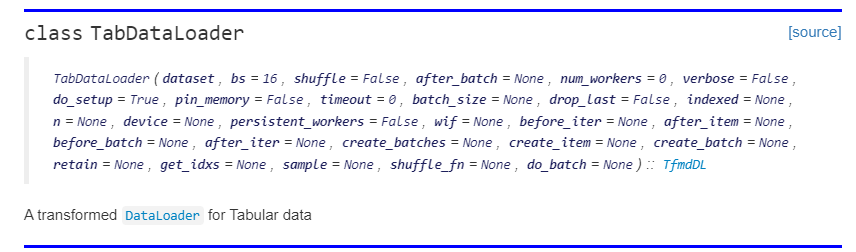

> Note! : `TabDataLoader` inherits from `TfmdDL` which inturn inherits from `Dataloader` class (pls check source-code)
        
-------       
- `TabularPandas` :It's a `Tabular` object with transforms
    - `Tabular` is a DataFrame wrapper that knows which cols are cont/cat/y, and returns rows in __getitem_

In [28]:
# creating TabDataloaders
trn_dl = TabDataLoader(tp.train, bs=64, shuffle=True, drop_last=True)
val_dl = TabDataLoader(tp.valid, bs=64)

In [29]:
# creating dataloaders
dls = DataLoaders(trn_dl, val_dl)

In [30]:
print("Dataloaders is just combining the train and validation TabDataloader")
print(dls.train == trn_dl)

# Tabular Learner

- Finally lets create the `NN!`
- `Tabular learner` automatically create a TabularModel suitable for your data and `infer the right loss function`

<u> Learner Params </u>
    
- Loss : `FlattenedLoss of CrossEntropyLoss()` : what's that. common, just google it!
- Optimizer : `Adam`
    
- Incase you are wondering, how `params #` are calc: just use ``` learn.embeds ``` 

In [31]:
# lets build the NN with 2 layer - [30, 10 Neurons]
learn = tabular_learner(dls, layers=[30,10], metrics=accuracy)

In [32]:
# model architecture
learn.summary()

In [33]:
print("size of embeddings")
print(learn.embeds)

- This is a real good fastai feature `lr_find`
- It lets you find the `optimum max_lr` - this is very handy if you are using fasti's `fit_one_cycle` 

- Not sure why `lr_max` is used ?? (`fit_one_cycle` is answer - it uses `cyclic LR`)

*read about it if you don't know :*
https://sgugger.github.io/the-1cycle-policy.html

In [34]:
learn.lr_find()

In [35]:
learn.fit_one_cycle(10, lr_max = 5e-2)

#  NN architecture [Optional]

- This part is slightly experimentational (basic understanding of `pytorch` is needed) - please bear me for any slight mistakes!😢

- Honestly, I was `not impressed` with the learner part above, thought I should add this too for `interested users`

---------

**Let's talk more about NN architecture - let's go step by step!**

[refer to NN arch.](#NN)

- At the start we have `7 embeddings` layers (explained earlier) for each of our 7 `categorical features` with respective sizes

- We also have a `Dropout` with `p == 0`, not sure why ?

- We have a `BatchNorm1d` layer of `size = 5`, why? `common you can guess this!!` (BTW do we need BatchNorm for categorical data in this case?)

- Then we have a sequential block with multiple  `[Linear, ReLU, Batchnorm]` layers
    - I am not going in as to why we need `Batchnorm` & `ReLU`
    
    - My only question is **why in_features == 168 for the first initial layer ?**
    
    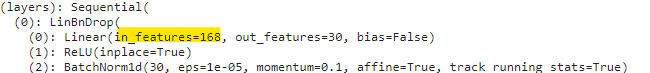
    
    - Let me try: 

        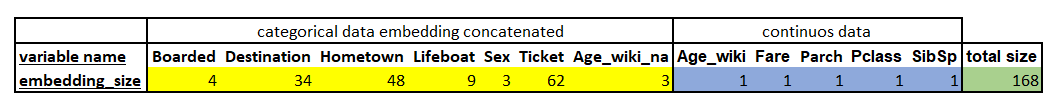

        - This is the step where we are **concatenating** the `categorical data embeddings` and `continuos data` [shown above]        
        
        - let's validate that : 
            if we are concatenating the categorical data embeddings then our column dimension should be
            
            **sum(Embeddings) + 5 (continuos features) == 168** 
            > [The above conition holds true as shown in the code below](#assert)
    
- After the 168 neuron Linear layer we have 2 more Linear layers giving 2 values for `binary classification` as `out_features` in the final layer

<a id="NN"></a> 
- `Learner architecture` 

In [36]:
print("This is how the model's architecture looks! \n")
learn.model

<a id="assert"></a> 
- `Assert if N_cont + N_cat_embed == 168`

In [37]:
concat_embed_size = sum([x.weight.shape[1] for x in learn.embeds])  # 163 size
n_cont_feat = 5 # continuos data

print("total size of concatenated categorical embeddings and continuos features equals ::",  concat_embed_size + n_cont_feat)

# Inference

- **Predicting the Test-set**

In [38]:
# imputing fare with median (coz training data did not have any missings for Fare)
fare_med_val = test_ext_fltr.Fare.median()
test_ext_fltr.loc[:,'Fare'].fillna(fare_med_val, inplace = True)

In [39]:
t1 = learn.dls.train_ds.new(test_ext_fltr)
t1.process()

dl = TabDataLoader(t1)
preds = learn.get_preds(dl=dl)[0].argmax(1).numpy()

In [40]:
out = pd.DataFrame({'PassengerId':test_ext.PassengerId, 'Survived': preds.astype(int)})
out.to_csv('submission_1.csv', index=False)
out.head()